In [227]:
import numpy as np
import random
import re
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
import scipy.io as sio   ## for loading octave matlab file
import math
import numpy.linalg as linalg

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.optimize #fmin_cg 

## Load Example Dataset

In [228]:
'''We start this exercise by using a small dataset that is easy to
%  visualize Our example case consists of 2 network server statistics across
%  several machines: the latency and throughput of each machine.
%  This exercise will help us find possibly faulty (or very fast) machines.
'''
mat_contents = sio.loadmat(r"C:\Users\user\Documents\Machine learning\machine-learning-ex8\ex8\ex8data1.mat")
mat_contents

# training data stored in arrays X
X=mat_contents['X']
   #### taking out X from the matrix
Xval = mat_contents['Xval']
yval = mat_contents['yval']

Text(0,0.5,'throughput (mb/s)')

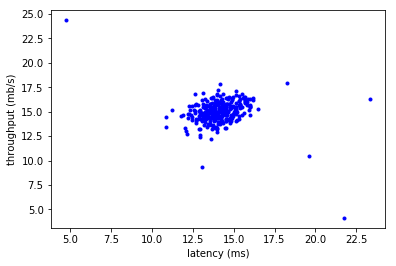

In [229]:
#%  Visualize the example dataset
plt.plot(X[:,0],X[:,1],'b.')
plt.xlabel('latency (ms)')
plt.ylabel('throughput (mb/s)')

### Estimate the dataset statistics

In [230]:
'''For this exercise, we assume a Gaussian distribution for the dataset.
%  We first estimate the parameters of our assumed Gaussian distribution, 
%  then compute the probabilities for each of the points and then visualize 
%  both the overall distribution and where each of the points falls in 
%  terms of that distribution.
'''
#Estimate my and sigma2
'''
This function estimates the parameters of a 
 Gaussian distribution using the data in X
%   The input X is the dataset with each n-dimensional data point in one row
%   The output is an n-dimensional vector mu, the mean of the data set
%   and the variances sigma^2, an n x 1 vector
% 
'''
def estimateGaussian(X):
    m,n = X.shape
    
    mu = np.zeros((n,1))
    sigma2 = np.zeros((n,1))    
    
    mu = X.mean(axis=0)
    sigma2 = X.var(axis = 0)
    
    return mu,sigma2

mu,sigma2 = estimateGaussian(X)
'''
Computes the probability 
%    density function of the examples X under the multivariate gaussian 
%    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
%    treated as the covariance matrix. If Sigma2 is a vector, it is treated
%    as the \sigma^2 values of the variances in each dimension (a diagonal
%    covariance matrix)
'''
def multivariateGaussian(X, mu, sigma2):
    ## FIRST convert your sigma2 vector into a diagonal matrix(which will be treated as covariance matrix)
    sigma2 = np.diag(sigma2)
    

    k = len(mu)

    X_minus_mu = X - mu
    coef = ((2*(np.pi))**(-k/2)) * ( (np.linalg.det(sigma2))**(-0.5) )
    #method 1  MAKE A MATRIX OF 307 * 307 AND TAKES OUT THE DIAGONAL ENTERIES 
    #expterm = (np.exp((-1/2)*X_minus_mu.dot(np.linalg.pinv(sigma2)).dot(X_minus_mu.T)))

    # method 2 USING EXERCISE IMPLEMENTATION
    expterm = np.exp( (-1/2)* np.sum( np.multiply(X_minus_mu.dot(np.linalg.pinv(sigma2)),X_minus_mu) ,axis=1) )  
    p = coef*expterm
    return p

In [231]:
p = multivariateGaussian(X,mu,sigma2) # Returns the density of the multivariate normal
                                      #  at each data point (row)  of X
'''
 Visualize the dataset and its estimated distribution.
 This visualization shows you the 
 probability density function of the Gaussian distribution. Each example
 has a location (x1, x2) that depends on its feature values.

'''
def VisualizeFit(X,mu,sigma2):

    xx = np.arange(0, 35, 0.5)    ## make a range from 0-35 with a spacing of 0.5
    yy = np.arange(0, 35, 0.5)
    X1,X2 = np.meshgrid(xx, yy)   ## use a meshgrid 
    
    grid = np.vstack((X1.flatten(),X2.flatten())).T   # making a grid of shape 4900 * 2 using X1,X
    #print(grid.shape)
    
    Z = multivariateGaussian(grid,mu,sigma2) ## calculating multivariate gaussian
    Z=Z.reshape(X1.shape)                    # reshape it to make a 2d array
    
    plt.plot(X[:,0],X[:,1],'b.')
    plt.xlabel('latency (ms)')
    plt.ylabel('throughput (mb/s)')
    plt.title('The Gaussian distribution contours of the distribution ﬁt to the dataset.')
    lev = np.arange(-20,0,3,dtype='float')    ## making a range for levels 

    levels = np.power(10,lev)          ##  now final levels are 10**-20, 10**-17, 10**-14 .... 
    if np.isinf(Z).sum() == 0:        ## checking that there should be no infinite value in Z
        plt.contour(X1,X2,Z,levels)

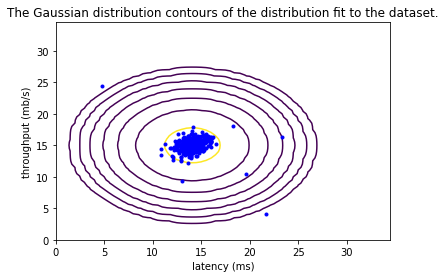

In [232]:
VisualizeFit(X,mu,sigma2)

### Find Outliers

##### Now you will find a good epsilon threshold using a cross-validation set probabilities given the estimated Gaussian distribution

In [233]:
pval = multivariateGaussian(Xval, mu, sigma2)
'''
   the functon below finds the best
   threshold to use for selecting outliers based on the results from a
   validation set (pval) and the ground truth (yval).

'''
'''
    Compute the F1 score of choosing epsilon as the
    threshold and place the value in F1. The code at the
    end of the loop will compare the F1 score for this
    choice of epsilon and set it to be the best epsilon if
    it is better than the current choice of epsilon.               
    Note: You can use predictions = (pval < epsilon) to get a binary vector
    of 0's and 1's of the outlier predictions
    '''
#For many diﬀerent values of ε, you will compute the resulting F1 score by computing how many 
#examples the current threshold classiﬁes correctly and incorrectly. The F1 score is computed
#using precision (prec) and recall (rec):
def selectThreshold(yval, pval):
    F1score = 0
    BestF1score = 0
    Bestepsilon = 0
    for epsilon in np.linspace(min(pval),max(pval),1000):
        
        cv_predictions = (pval<epsilon).astype(np.int).reshape(len(pval),1)

        tp = sum((cv_predictions == 1) & (yval == 1) )[0]
        fp = sum((cv_predictions == 1) & (yval == 0) )[0]
        fn = sum((cv_predictions == 0) & (yval == 1) )[0]

        prec = (tp/(tp+fp))
        rec = (tp/(tp+fn))

        F1score = (2*prec*rec)/(prec+rec)
       
        if (F1score > BestF1score):
            Bestepsilon = epsilon
            BestF1score = F1score
    return BestF1score,Bestepsilon

In [234]:
BestF1score,Bestepsilon = selectThreshold(yval, pval)

print('BestF1score =',BestF1score)
print('Bestepsilon =',Bestepsilon)


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars


BestF1score = 0.8750000000000001
Bestepsilon = 8.999852631901395e-05


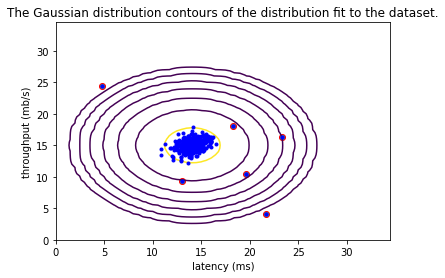

In [235]:

 #Find the outliers in the training set and mark them with red circles
outliers = (p < epsilon)
outliers = np.where(outliers == True)
VisualizeFit(X,mu,sigma2)
plt.scatter(X[outliers][:,0],X[outliers][:,1],marker='o',facecolors=None,edgecolors='r')

### Multidimensional Outliers

In [236]:
'''
%  We will now use the code from the previous part and apply it to a 
%  harder problem in which more features describe each datapoint and only 
%  some features indicate whether a point is an outlier.

'''
#Loads the second dataset. You should now have the variables X, Xval, yval in your environment


'\n%  We will now use the code from the previous part and apply it to a \n%  harder problem in which more features describe each datapoint and only \n%  some features indicate whether a point is an outlier.\n\n'

In [237]:
high_dimensional = sio.loadmat(r"C:\Users\user\Documents\Machine learning\machine-learning-ex8\ex8\ex8data2.mat")
high_dimensional

# training data stored in arrays X
X=high_dimensional['X']

#### taking out X from the matrix
Xval = high_dimensional['Xval']
yval = high_dimensional['yval']

In [238]:
#Apply the same steps to the larger dataset 
mu,sigma2 = estimateGaussian(X)

#Training set 
p = multivariateGaussian(X, mu, sigma2)
#Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

BestF1score,Bestepsilon = selectThreshold(yval, pval)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars


In [239]:
print('Best epsilon found using cross-validation: ', Bestepsilon)
print('Best F1 on Cross Validation Set:  ', BestF1score)
print('   (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of 0.615385)')
print('# Outliers found: ', sum(p < Bestepsilon))


Best epsilon found using cross-validation:  1.3786074982000245e-18
Best F1 on Cross Validation Set:   0.6153846153846154
   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)
# Outliers found:  117
